# Feedforward Network with Credit Card Default

Let us look at a BigDL example with Credit Card Default.  We will train a simple, feedforward neural network with 

In [2]:
%matplotlib inline
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
import seaborn as sn
import pandas as pd
import random as rd
import datetime as dt


from bigdl.dataset.transformer import *
from bigdl.dataset.base import *
from bigdl.nn.layer import *
from bigdl.nn.criterion import *
from bigdl.optim.optimizer import *
from bigdl.util.common import *
from utils import *
from bigdl.models.ml_pipeline.dl_classifier import *


from pyspark.sql.types import DoubleType
from pyspark.sql.functions import col, udf
from pyspark.ml import  Pipeline
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator




init_engine()

In [3]:
learning_rate = 0.1
training_epochs = 20
batch_size = 1024
display_step = 1

# Network Parameters
n_input = 5
n_classes = 2
n_hidden_1 = 3 # 1st layer number of features
n_hidden_2 = 2 # 1st layer number of features



filename =  "../data/cc-default/default-simple.csv"

LABELS = ["Good", "Default"] 

In [4]:
# Number of hidden layers

n_hidden_guess = np.sqrt(np.sqrt((n_classes + 2) * n_input) + 2 * np.sqrt(n_input /(n_classes+2.)))
print("Hidden layer 1 (Guess) : " + str(n_hidden_guess))

n_hidden_guess_2 = n_classes * np.sqrt(n_input / (n_classes + 2.))
print("Hidden layer 2 (Guess) : " + str(n_hidden_guess_2))

Hidden layer 1 (Guess) : 2.59002006411
Hidden layer 2 (Guess) : 2.2360679775


In [5]:
cc_training = spark.read.csv(filename, header=True, inferSchema="true", mode="DROPMALFORMED")
cc_training = cc_training.withColumn('label', cc_training.default.cast("double"))

In [6]:
cc_training.show()

+---+-------+---+---------+--------+---+-------+-----+
| id|balance|sex|education|marriage|age|default|label|
+---+-------+---+---------+--------+---+-------+-----+
|  1|  20000|  2|        2|       1| 24|      2|  2.0|
|  2| 120000|  2|        2|       2| 26|      2|  2.0|
|  3|  90000|  2|        2|       2| 34|      1|  1.0|
|  4|  50000|  2|        2|       1| 37|      1|  1.0|
|  5|  50000|  1|        2|       1| 57|      1|  1.0|
|  6|  50000|  1|        1|       2| 37|      1|  1.0|
|  7| 500000|  1|        1|       2| 29|      1|  1.0|
|  8| 100000|  2|        2|       2| 23|      1|  1.0|
|  9| 140000|  2|        3|       1| 28|      1|  1.0|
| 10|  20000|  1|        3|       2| 35|      1|  1.0|
| 11| 200000|  2|        3|       2| 34|      1|  1.0|
| 12| 260000|  2|        1|       2| 51|      1|  1.0|
| 13| 630000|  2|        2|       2| 41|      1|  1.0|
| 14|  70000|  1|        2|       2| 30|      2|  2.0|
| 15| 250000|  1|        1|       2| 29|      1|  1.0|
| 16|  500

In [7]:
cc_training.select('balance','sex','education','marriage','age','default').describe().show()

+-------+------------------+------------------+------------------+------------------+-----------------+------------------+
|summary|           balance|               sex|         education|          marriage|              age|           default|
+-------+------------------+------------------+------------------+------------------+-----------------+------------------+
|  count|             30000|             30000|             30000|             30000|            30000|             30000|
|   mean|167484.32266666667|1.6037333333333332|1.8531333333333333|1.5518666666666667|          35.4855|            1.2212|
| stddev|129747.66156720246|0.4891291960902602|0.7903486597207269|0.5219696006132467|9.217904068090155|0.4150618056909329|
|    min|             10000|                 1|                 0|                 0|               21|                 1|
|    max|           1000000|                 2|                 6|                 3|               79|                 2|
+-------+-------

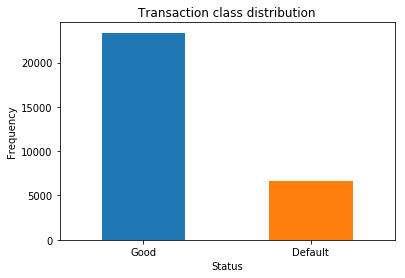

In [8]:
#count_classes = pd.value_counts(df['Class'], sort = True)
count_classes = pd.value_counts(cc_training.select('default').toPandas()['default'], sort = True)
count_classes.plot(kind = 'bar', rot=0)
plt.title("Transaction class distribution")
plt.xticks(range(2), LABELS)
plt.xlabel("Status")
plt.ylabel("Frequency");

In [9]:
(trainingData, validData) = cc_training.select('balance','sex','education','marriage','age','label').randomSplit([.7,.3])

In [10]:
assembler =  VectorAssembler(inputCols=['balance','sex','education','marriage','age'], outputCol="assembled")
scaler = StandardScaler(inputCol="assembled", outputCol="features")
pipeline = Pipeline(stages = [assembler, scaler])
pipelineTraining = pipeline.fit(trainingData)
cc_data_training = pipelineTraining.transform(trainingData)
pipelineTest = pipeline.fit(validData)
cc_data_test = pipelineTest.transform(validData)

In [21]:
np.array(cc_data_training.select('features').collect())

array([[[ 0.07713293,  2.04703291,  1.26444402,  1.91475904,  4.4585972 ]],

       [[ 0.07713293,  2.04703291,  1.26444402,  1.91475904,  5.43731365]],

       [[ 0.07713293,  2.04703291,  1.26444402,  3.82951807,  2.39241801]],

       ..., 
       [[ 5.78496992,  4.09406582,  3.79333205,  1.91475904,  4.34985092]],

       [[ 5.86210285,  2.04703291,  3.79333205,  1.91475904,  5.87229875]],

       [[ 6.01636872,  2.04703291,  1.26444402,  1.91475904,  5.21982111]]])

In [ ]:
bigDLModel = Sequential().add(Linear(n_input, n_hidden_1)).add(Linear(n_hidden_1, n_classes)).add(LogSoftMax())
classnll_criterion = ClassNLLCriterion()
dlClassifier = DLClassifier(model=bigDLModel, criterion=classnll_criterion, feature_size=[n_input])
dlClassifier.setLabelCol("default").setMaxEpoch(training_epochs).setBatchSize(batch_size)
model = dlClassifier.fit(cc_data_training)
print("\ninitial model training finished.")

In [ ]:
from pyspark.sql import DataFrame, SQLContext
predictionDF = DataFrame(model.transform(cc_data_test), SQLContext(sc))
predictionDF

In [ ]:
predictionDF.cache()
evaluator = BinaryClassificationEvaluator(rawPredictionCol="prediction")
auPRC = evaluator.evaluate(predictionDF)
print("\nArea under precision-recall curve: = " + str(auPRC))
    
recall = MulticlassClassificationEvaluator(metricName="weightedRecall").evaluate(predictionDF)
print("\nrecall = " + str(recall))

precision = MulticlassClassificationEvaluator(metricName="weightedPrecision").evaluate(predictionDF)
print("\nPrecision = " + str(precision))
predictionDF.unpersist()

In [ ]:
y_pred = np.array(predictionDF.select('prediction').collect())
y_true = np.array(predictionDF.select('label').collect())

In [ ]:
acc = accuracy_score(y_true, y_pred)
print("The prediction accuracy is %.2f%%"%(acc*100))

cm = confusion_matrix(y_true, y_pred)
cm.shape
df_cm = pd.DataFrame(cm)
plt.figure(figsize = (10,8))
sn.heatmap(df_cm, annot=True,fmt='d');